In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
np.random.seed(7)

Importe el dataset de EMNIST con 112,000 caracteres alfanumericos escritos a mano.

In [2]:
training_letter = pd.read_csv('balanced.csv')

In [3]:
print(training_letter.shape)

(112799, 785)


In [4]:
y = np.array(training_letter.iloc[:,0].values)
x = np.array(training_letter.iloc[:,1:].values)
print(y.shape)
print(x.shape)

(112799,)
(112799, 784)


In [5]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], dtype=int64)

In [6]:
d = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9', 
10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F',16:'G',17:'H',
18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',
27:'R',28:'S',29:'T',30:'U',31:'V',32:'W',33:'X',34:'Y',35:'Z',
36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',46:'t'}
yshow = np.vectorize(d.get)(y)

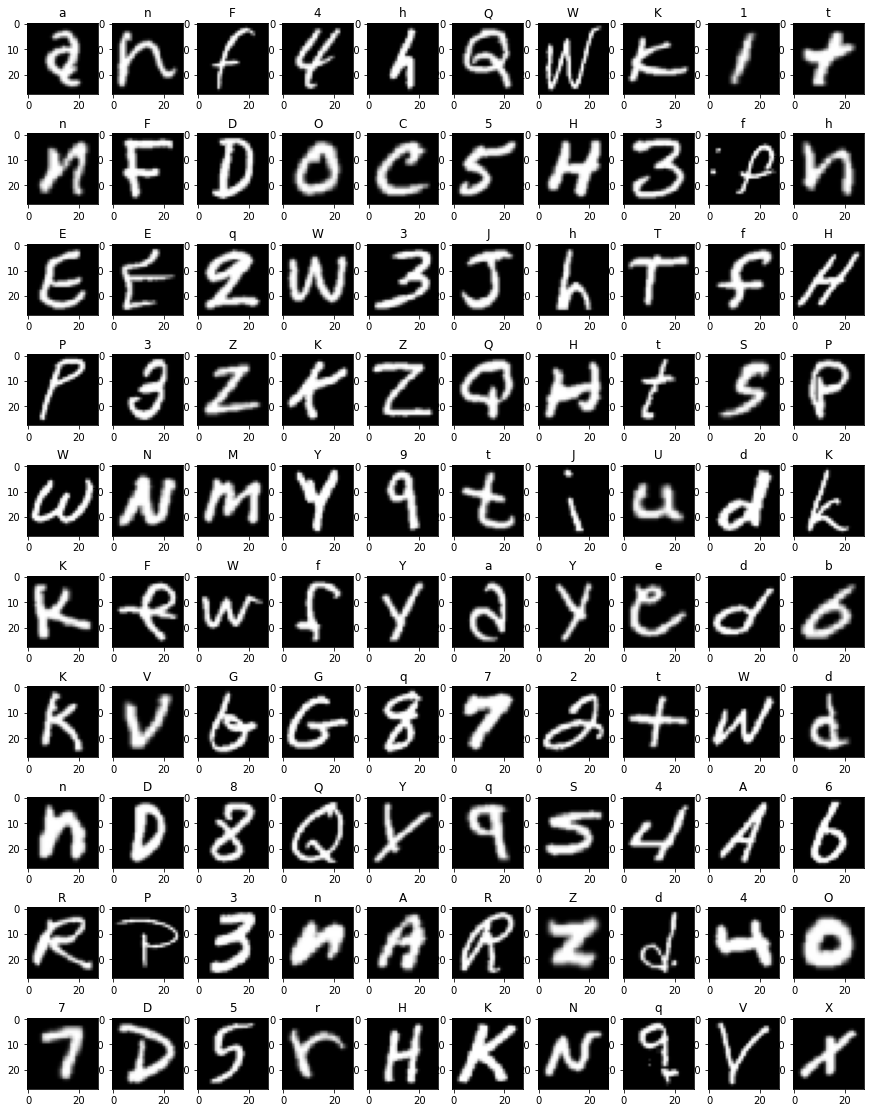

In [7]:
fig,axes = plt.subplots(10,10,figsize=(15,20))
for i,ax in enumerate(axes.flat):
    ax.imshow(x[i].reshape([28,28]).T, cmap=plt.get_cmap('gray'))
    ax.title.set_text(yshow[i])

C:\Users\eric8\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

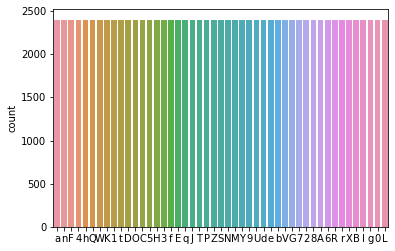

In [8]:
sns.countplot(yshow)

El dataset es balanceado.

In [9]:
train_images = x / 255.0
train_images_number = train_images.shape[0]
train_images_height = 28
train_images_width = 28
train_images = train_images.reshape(train_images_number, train_images_height, train_images_width, 1)
train_images = np.swapaxes(train_images,1,2)

In [10]:
number_of_classes = 47
ycat = tf.keras.utils.to_categorical(y, number_of_classes)

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, ycat, test_size = 0.1, random_state=7)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, Dropout, 
                          MaxPooling2D, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
#Define arquitecture
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same' ))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(47, activation='softmax'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(optimizer=optimizer, 
              loss="categorical_crossentropy", metrics=["accuracy"])

reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=1, save_best_only=True)

In [14]:
history = model.fit(X_train, Y_train,
          batch_size=256,
          epochs=20,
          validation_data = (X_val,Y_val),
          callbacks = [reduce_lr,checkpointer],
          verbose=1)

Epoch 1/20
397/397 [==============================] - ETA: 0s - loss: 1.2951 - accuracy: 0.6196
Epoch 00001: val_loss improved from inf to 4.66615, saving model to model.h5
397/397 [==============================] - 226s 570ms/step - loss: 1.2951 - accuracy: 0.6196 - val_loss: 4.6662 - val_accuracy: 0.0936
Epoch 2/20
397/397 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.7710
Epoch 00002: val_loss improved from 4.66615 to 0.52002, saving model to model.h5
397/397 [==============================] - 223s 561ms/step - loss: 0.7064 - accuracy: 0.7710 - val_loss: 0.5200 - val_accuracy: 0.8218
Epoch 3/20
397/397 [==============================] - ETA: 0s - loss: 0.5957 - accuracy: 0.8021
Epoch 00003: val_loss improved from 0.52002 to 0.47606, saving model to model.h5
397/397 [==============================] - 221s 557ms/step - loss: 0.5957 - accuracy: 0.8021 - val_loss: 0.4761 - val_accuracy: 0.8307
Epoch 4/20
397/397 [==============================] - ETA: 0s - loss

In [36]:
model.evaluate(X_val, Y_val)

353/353 [==============================] - 4s 10ms/step - loss: 0.3389 - accuracy: 0.8809


[0.338912695646286, 0.8809397220611572]

In [47]:
import cv2
#Extrae los caracteres separados del captcha en 28x28
def arrCaptcha(name):
    image = cv2.imread(name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray,11,17,17)
    gray = cv2.inRange(gray, 220, 255)

    contours, hierarchy = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]

    conts = []
    for con in contours:
        (x, y, w, h) = cv2.boundingRect(con)
        if (w > 5) and (h > 5):
            conts.append((x, y, w, h))

    conts = sorted(conts, key=lambda x: x[0])

    news = []
    for box in conts:
        x, y, w, h = box
        letter_image = gray[y:y + h, x:x + w]
        new_img = cv2.resize(letter_image, (22, 24), interpolation=cv2.INTER_AREA) 
        out = cv2.copyMakeBorder(new_img,2,2,3,3,cv2.BORDER_CONSTANT,value=0)
        news.append(out)
    
    arr = np.array(news)/255
    arr = arr.reshape(arr.shape[0], 28, 28, 1)
    return arr

In [38]:
def arrToString(s):  
    str1 = ""   
    for ele in s:  
        str1 += ele    
    return str1

In [39]:
#usa el CNN para predecir cada caracter y los junta
def predCaptcha(name):
    arr = arrCaptcha(name)
    Y_pred = model.predict(arr)
    Y_pred_class = np.argmax(Y_pred,axis = 1)
    mypred = np.vectorize(d.get)(Y_pred_class)
    predicted_word = arrToString(mypred)
    return predicted_word

In [40]:
#9 imagenes de ejemplo
images = 'abcdefghi'
labs = []
for i in images:
    labs.append(predCaptcha(i))

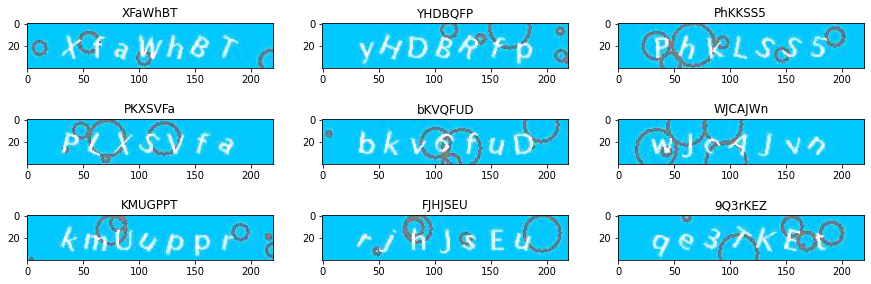

In [41]:
fig,axes = plt.subplots(3,3,figsize=(15,5))
for i,ax in enumerate(axes.flat):
    captch = cv2.imread(images[i]+".jpg")
    ax.imshow(captch)
    ax.title.set_text(labs[i])

Accuracy: alrededor del 80%
1 a 2 errores por palabra

Usando una libreria externa en imagenes limpias para comparar:

In [42]:
import easyocr
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [43]:
labsEasy = []
for i in images:
    img = cv2.imread(i+".jpg")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray,11,17,17)
    gray = cv2.inRange(gray, 220, 255)
    gray = cv2.bitwise_not(gray)
    labsEasy.append(reader.readtext(gray, detail = 0))


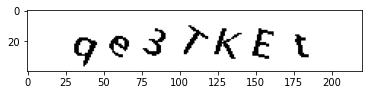

In [44]:
plt.imshow(gray, cmap='gray')

imagen limpia

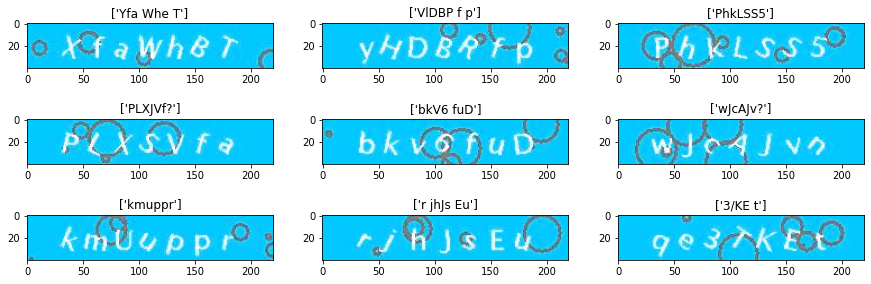

In [45]:
fig,axes = plt.subplots(3,3,figsize=(15,5))
for i,ax in enumerate(axes.flat):
    captch = cv2.imread(images[i]+".jpg")
    ax.imshow(captch)
    ax.title.set_text(labsEasy[i])

Mi implementacion tuvo mejores resultados que easyOCR aun despues de limpiar la imagen.

csv con todas las labels:

In [49]:
import os
tocsv = []
for filename in os.listdir('captchas/'):
    tocsv.append((filename,predCaptcha('captchas/'+filename)))

In [54]:
len(tocsv)

700

In [55]:
import pandas as pd
df = pd.DataFrame(tocsv)  
df.to_csv('captchas.csv')  